In [1]:
pip install numpy pandas torch matplotlib transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer

In [3]:
# Define the pre-trained model to use
MODEL_NAME = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [4]:
def load_dataset(filepath):
    # Load dataset from a file in CoNLL-like format
    final = []
    sentences = []

    with open(filepath, 'r') as f:
        for line in f.readlines():
            # empty line indicates sentence boundary
            if line == "\n":
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[1].strip('\n')))

    return final

# Load datasets
train_samples = load_dataset('dataNER/train.txt')
test_samples = load_dataset('dataNER/test.txt')
valid_samples = load_dataset('dataNER/valid.txt')

In [5]:
samples = train_samples + test_samples

# Create the tag schema (all unique tags + padding '_')
schema = ['_'] + sorted({tag for sentence in samples for _, tag in sentence})

In [6]:
def tokenize_sample(sample):
    # Convert each word to subtokens and keep its tag. It's a function which tokenize a single sample
    seq = [
        (subtoken, tag)
        for token, tag in sample
        for subtoken in tokenizer(token)['input_ids'][1:-1]
    ]
    # Add special tokens [CLS] (3) at start and [SEP] (4) at end with 'O' tag
    return [(3, 'O')] + seq + [(4, 'O')]


def preprocess(samples, schema):
    # Map each tag to an index
    tag_index = {tag: i for i, tag in enumerate(schema)}
    # Tokenize all samples
    tokenized_samples = list(map(tokenize_sample, samples))

    # Find the maximum sequence length and initialize arrays for input IDs and labels
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)

    # Fill arrays with token IDs and label indices
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i, j] = tag_index[tag]

    return X, y

# Preprocess the data
X_train, y_train = preprocess(train_samples, schema)
X_test, y_test = preprocess(test_samples, schema)
X_valid, y_valid = preprocess(valid_samples, schema)

In [7]:
# Convert to PyTorch datasets
train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.long),
    torch.tensor(y_train, dtype=torch.long),
)
test_ds = TensorDataset(
    torch.tensor(X_test, dtype=torch.long),
    torch.tensor(y_test, dtype=torch.long),
)
valid_ds = TensorDataset(
    torch.tensor(X_valid, dtype=torch.long),
    torch.tensor(y_valid, dtype=torch.long),
)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)
valid_loader = DataLoader(valid_ds, batch_size=8)

# Load model configuration and initialize model
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(schema),
)

model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, config=config)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 3
train_losses = []
val_losses = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS} - Train Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_loss_total = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(input_ids=input_ids, labels=labels)
            val_loss_total += outputs.loss.item()

    val_loss = val_loss_total / len(test_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS} - Valid Loss: {val_loss:.4f}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/3 - Train Loss: 0.6942
Epoch 1/3 - Valid Loss: 0.3881
Epoch 2/3 - Train Loss: 0.2451
Epoch 2/3 - Valid Loss: 0.1474
Epoch 3/3 - Train Loss: 0.1026
Epoch 3/3 - Valid Loss: 0.0738


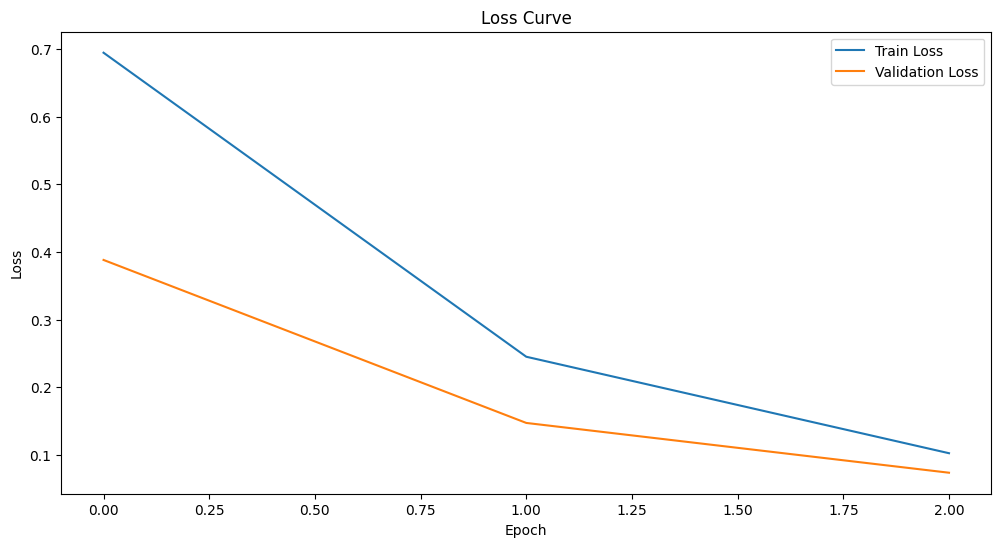

In [8]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [9]:
# Evaluation on validation set
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for batch in valid_loader:
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        logits = model(input_ids=input_ids).logits
        preds = torch.argmax(logits, dim=-1)

        # Only consider non-padding tokens
        mask = labels != 0
        correct += (preds[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

accuracy = correct / total
print(f"Final Accuracy: {accuracy:.3f}")

Final Accuracy: 0.958


In [10]:
def predict_sentence(model, sentence, tokenizer, schema, device):
    model.eval()
    inputs = tokenizer(sentence, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids).logits
        predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tags = [schema[p] for p in predictions]

    for token, tag in zip(tokens, tags):
        print(f"{token:15} -> {tag}")

print("\nPrediction on Example 1:")
predict_sentence(model, "I think Mount Everest looks beautiful", tokenizer, schema, device)

print("\nPrediction on Example 2:")
predict_sentence(model, "She came to France yesterday", tokenizer, schema, device)


Prediction on Example 1:
[CLS]           -> O
I               -> O
think           -> O
Mount           -> B-MOUNTAIN
Everest         -> O
looks           -> O
beautiful       -> O
[SEP]           -> B-MOUNTAIN

Prediction on Example 2:
[CLS]           -> O
She             -> O
came            -> O
to              -> O
France          -> O
yesterday       -> O
[SEP]           -> O
